In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, ward_tree
from sklearn.metrics import plot_confusion_matrix, accuracy_score, mean_squared_error
from sklearn.naive_bayes import GaussianNB
import yfinance as yf
import pmdarima as pm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Aquisição dos dados

|Country|Index|Ticker|
|---        |---        |---        |
|Brazil|iBovespa|^BVSP|
|USA|Nasdaq Composite|^IXIC|
|USA|NYSE Composite|^NYA|
|USA|Dow Jones|^DJI|
|Argentina|Merval|M.BA|
|Japan|Nikkei 225|^N225|
|China|Shangai Composite|000001.SS|
|China|Hang Seng|^HSI|
|India|BSE 30 Sensex|^BSESN|
|UK|FTSE 100|^FTSE|
|Sweden|Stockholm General|^OMX|
|Germany|Dax|^GDAXI|
|France|Cac 40|^FCHI|

In [42]:
start_date = "2011-01-01"
end_date = "2022-01-01"

df_ibovespa = yf.download("^BVSP", start=start_date, end=end_date)

# Indices de bolsas:
# ^BVSP
# ^IXIC
# ^NYA
# ^DJI
# M.BA
# ^N225
# 000001.SS
# ^HSI
# ^BSESN
# ^FTSE
# ^OMX
# ^GDAXI
# ^FCHI


[*********************100%***********************]  1 of 1 completed


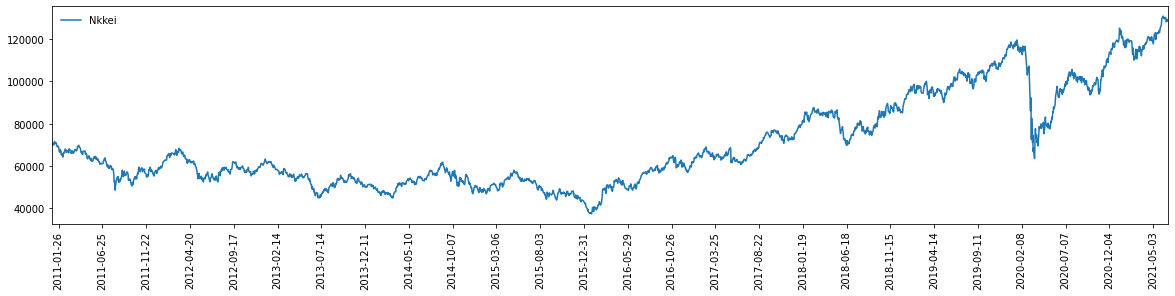

In [43]:
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(111)

ax.plot(df_ibovespa['Close'], label="Nkkei")

date_min = df_ibovespa.index.min()
date_max = df_ibovespa.index.max()
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
ax.set_xlim(left=date_min, right=date_max)

ax.legend(loc='upper left', frameon=False)
plt.xticks(rotation=90)
plt.show();

## Preparação dos dados

Nesta seção, tomaremos as seguintes ações:

1. Separação do conjunto de dados de treinamento (01/01/2011 até 30/04/2021) e de validação do modelo (01/05/2021 até 30/05/2021).
1. Criação do atributo **"p/e"**: $ p/e = 100*(ln({r_{t}}) - ln({r_{t-1}})) $.
1. Criação da resposta **cluster** usando apenas a simples separação. Lembrando que no artigo, os autores compararam duas abordagens diferentes para discretizar a resposta ((a) simples separação e (b) Ward).

In [47]:

X_train = df_ibovespa[:"2021-06-01"]
X_test = df_ibovespa["2021-06-01":]
# X_train = df_ibovespa[:-Ntest]
# X_test = df_ibovespa[-Ntest:]

print(f"""Base original: {df_ibovespa.shape}
X_train: {X_train.shape}
X_test: {X_test.shape}\n""")
Ntest = X_test.shape[0]

X_train["rt"] = (np.log(X_train["Close"]) - np.log(X_train["Close"].shift(periods=1)))*100
X_test["rt"] = (np.log(X_test["Close"]) - np.log(X_test["Close"].shift(periods=1)))*100
df_ibovespa["rt"] = (np.log(df_ibovespa["Close"]) - np.log(df_ibovespa["Close"].shift(periods=1)))*100
X_train = X_train[["Close", "rt"]][1:]
X_train.head()

Base original: (2587, 7)
X_train: (2572, 7)
X_test: (16, 7)



,Close,rt
Date,,
2011-01-04,70318.0,0.507557
2011-01-05,71091.0,1.093293
2011-01-06,70579.0,-0.722810
2011-01-07,70057.0,-0.742345
2011-01-10,70127.0,0.099869


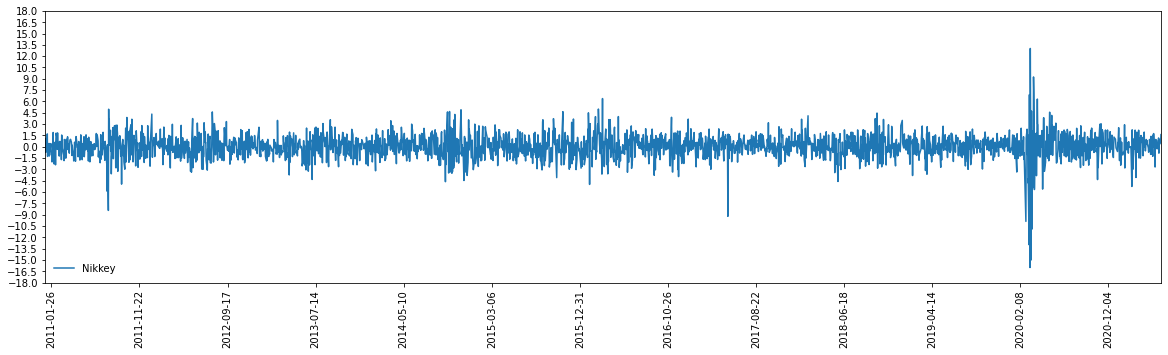

In [48]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)

date_min = X_train.index.min()
date_max = X_train.index.max()

ax.plot(X_train['rt'], label="Nikkey")

ax.xaxis.set_major_locator(plt.MaxNLocator(13))
ax.yaxis.set_major_locator(plt.MaxNLocator(30))
ax.set_ylim(-18, 18)
ax.set_xlim(left=date_min, right=date_max)

ax.legend(loc='lower left', frameon=False)
plt.xticks(rotation=90)
plt.show();

count    2571.000000
mean        0.023577
std         1.619532
min       -15.993027
25%        -0.825346
50%         0.033257
75%         0.909244
max        13.022281
Name: rt, dtype: float64

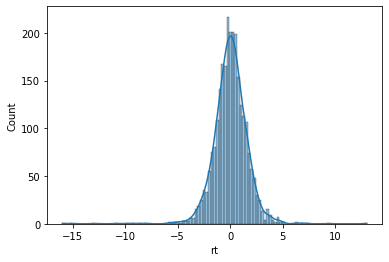

In [49]:
sns.histplot(data=X_train, x="rt", kde=True);
X_train['rt'].describe().T

### ARIMA



In [50]:
X_train

,Close,rt
Date,,
2011-01-04,70318.0,0.507557
2011-01-05,71091.0,1.093293
2011-01-06,70579.0,-0.722810
2011-01-07,70057.0,-0.742345
2011-01-10,70127.0,0.099869
...,...,...
2021-05-26,123989.0,0.810606
2021-05-27,124367.0,0.304402
2021-05-28,125561.0,0.955482


In [51]:
model = pm.auto_arima(X_train['rt'], erro_action='ignore', trace=True, suppress_warnings=True, maxinter=10, stepwise=False, seasonal=False)

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9776.876, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=9757.359, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=9753.401, Time=0.14 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=9755.065, Time=0.21 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=9757.001, Time=0.25 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=9754.754, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=9755.462, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=9754.545, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=9755.190, Time=0.25 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=9757.057, Time=0.38 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=9745.057, Time=0.73 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=9753.374, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=9755.357, Time=0.19 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=9721.905, Time=0.45 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=9723.829, Time=1.08 sec
 ARIMA(3,0

In [52]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2571
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -4855.953
Date:                Thu, 24 Jun 2021   AIC                           9721.905
Time:                        00:41:04   BIC                           9751.165
Sample:                             0   HQIC                          9732.513
                               - 2571                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6377      0.028    -59.061      0.000      -1.692      -1.583
ar.L2         -0.8142      0.029    -28.500      0.000      -0.870      -0.758
ma.L1          1.5555      0.033     47.772      0.000       1.492       1.619
ma.L2          0.7229      0.034     21.230      0.000       0.656       0.790
sigma2         2.5589      0.030     86.050      0.000       2.501       2.617
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             12951.81
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.69   Skew:                            -0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
model.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (2, 0, 2),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [54]:
def plot_result(model, fulldata, train, test):
    params = model.get_params()
    d = params['order'][1]

    train_pred = model.predict_in_sample(start=d, end=-1)
    test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(fulldata.index, fulldata, label='data')
    ax.plot(train.index[d:], train_pred, label='fitted')
    ax.plot(test.index, test_pred, label='forecast')
    ax.fill_between(test.index, confint[:,0], confint[0:,1], color='red', alpha=0.3)
    ax.legend();

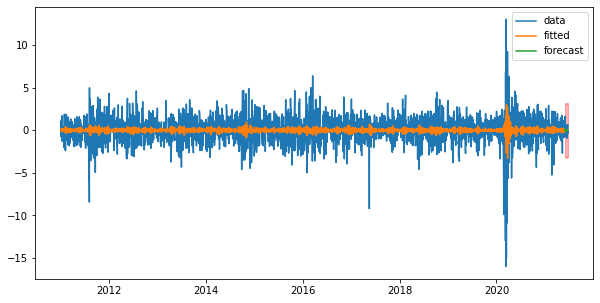

In [55]:
plot_result(model, df_ibovespa["rt"], X_train['rt'], X_test['rt'])

In [56]:
def plot_test(model, test):
    test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(test.index, test, label='true')
    ax.plot(test.index, test_pred, label='forecast')
    ax.fill_between(test.index, confint[:,0], confint[0:,1], color='red', alpha=0.3)
    ax.legend();

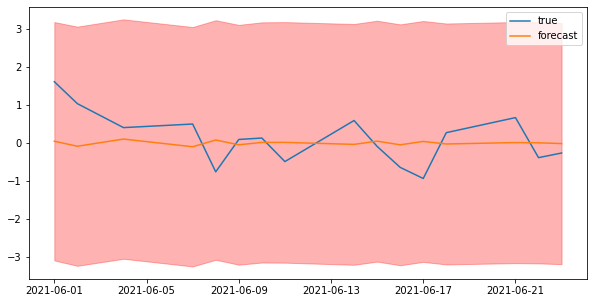

In [57]:
plot_test(model, X_test['rt'])

In [58]:
def rmse(y, t):
    return np.sqrt(np.mean((t - y)**2))

In [59]:
predictions = model.predict(Ntest)
# predictions2 = predictions.reshape(Ntest,1)

In [60]:
# predictions2= predictions2.reshape(1,-1)[0]

In [61]:
a = rmse(predictions, X_test["rt"])

In [62]:
#print("RSME ARIMA:", round(rmse(predictions, X_test["rt"]), 4))
print(f"RSME ARIMA: {round(a, 4)}%")
print("RSME Naive:", rmse(X_train['rt'].iloc[-1], X_test['rt']))

RSME ARIMA: 0.6889%
RSME Naive: 1.6445597957878584


In [63]:
predictions

array([ 0.04577434, -0.08564594,  0.10299465, -0.09894436,  0.07818635,
       -0.04748846,  0.01411496,  0.01554764, -0.03695447,  0.04786208,
       -0.0482967 ,  0.0401278 , -0.02639569,  0.01055742,  0.00420069,
       -0.01547506])

In [64]:
X_test['rt_predict'] = predictions
X_test.fillna(value=0, inplace=True)
X_test = X_test.round(3)

X_test

,Open,High,Low,Close,Adj Close,Volume,rt,rt_predict
Date,,,,,,,,
2021-06-01,126218.0,128363.0,126218.0,128267.000,128267.000,12496100,1.612,0.046
2021-06-02,128268.0,129601.0,128167.0,129601.000,129601.000,12781100,1.035,-0.086
2021-06-04,129600.0,130137.0,129148.0,130126.000,130126.000,9814800,0.404,0.103
2021-06-07,130125.0,131190.0,129498.0,130776.000,130776.000,9655400,0.498,-0.099
2021-06-08,130776.0,130776.0,129230.0,129787.000,129787.000,10346600,-0.759,0.078
2021-06-09,129800.0,130882.0,129281.0,129907.000,129907.000,9833700,0.092,-0.047
2021-06-10,129911.0,130527.0,129526.0,130076.000,130076.000,8537900,0.130,0.014
2021-06-11,130076.0,130294.0,128678.0,129441.000,129441.000,7748200,-0.489,0.016
2021-06-14,129441.0,131084.0,129441.0,130208.000,130208.000,8155700,0.591,-0.037


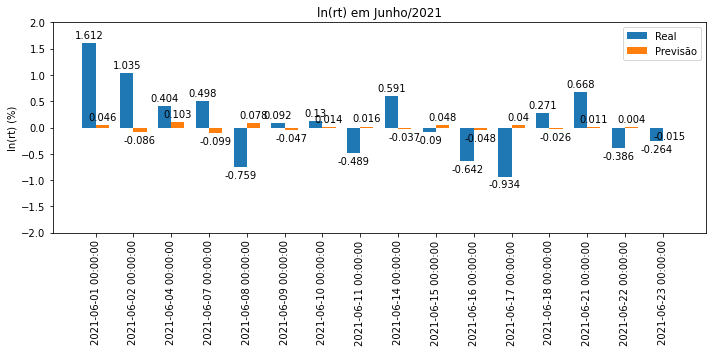

In [71]:

x = np.arange(len(X_test))
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, X_test['rt'], width, label='Real')
rects2 = ax.bar(x + width/2, X_test['rt_predict'], width, label='Previsão')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('ln(rt) (%)')
ax.set_title('ln(rt) em Junho/2021')
ax.set_xticks(x)
ax.set_xticklabels(X_test.index)
plt.xticks(rotation=90)

ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.ylim((-2,2))
plt.show()